In [439]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from scipy.stats import wilcoxon
from scipy import stats

In [347]:
# Path to aligned data
# data_alingned_path = '/mnt/disk2/Arthur_data/B6J3217-2025-07-02T13-13-14_processedData/aligned_data/B6J3217_downsampled_data_Apply halt: 2s_aligned.csv'
data_alingned_path = '/mnt/disk2/Arthur_data/B6J2718-2024-12-10T12-57-02_processedData/aligned_data/B6J2718_downsampled_data_Apply halt_2s_aligned.csv'

data_aligned_csv = pd.read_csv(data_alingned_path)

# Creation of new column with index of each MM
halt_index = 0
halt_indices = []
prev_halt_time = None

for _, row in data_aligned_csv.iterrows():
    if row['Halt Time'] != prev_halt_time:
        halt_index += 1
        prev_halt_time = row['Halt Time']
    halt_indices.append(halt_index-1)

data_aligned_csv['halt_index'] = halt_indices

bin_indices = []

for _, row in data_aligned_csv.iterrows():
    th_time = 10
    for i in range(8):
        if row['Time (s)'] <= th_time:
            bin_index = 7-i
            th_time -=2
    
    bin_indices.append(bin_index)

data_aligned_csv['bin_index'] = bin_indices

# Printing every column names to see every variables
col_names = data_aligned_csv.columns
print("\n".join(col_names))


Encoder
Position_0X
Position_0Y
CumulativeCounts_0X
CumulativeCounts_0Y
dfF_470
dfF_560
dfF_410
z_470
z_560
z_410
Photodiode_int
Encoder_Unwrapped
Motor_Velocity
Motor_Acceleration
Velocity_0X
Acceleration_0X
Velocity_0Y
Acceleration_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1
saccade_event_eye1
saccade_event_eye2
Time (s)
Halt Time
saccade_probability_eye1
halt_index
bin_index


## Getting data for all MM across the session

## Getting the % change in running and turning speed from 2s before to 2s after MM

In [544]:
dict_changes_turning_speed = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_changes_running_speed = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_changes_activ = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_activ_mean_after_mm = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_changes_ellipse_X = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_changes_ellipse_Y = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_changes_pupil_diam = {MM: [] for MM in data_aligned_csv['halt_index']}


for i in range(np.max(data_aligned_csv['halt_index'])+1):
    spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == i]

    spe_halt_bin_before_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 2]
    spe_halt_bin_after_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 3]

    mean_turning_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0Y']))
    mean_turning_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0Y']))

    mean_running_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0X']))
    mean_running_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0X']))

    mean_activ_before = np.mean(np.abs(spe_halt_bin_before_data['z_560']))
    mean_activ_after = np.mean(np.abs(spe_halt_bin_after_data['z_560']))

    mean_ellipse_X_before = np.mean(np.abs(spe_halt_bin_before_data['Ellipse.Center.X_eye1']))
    mean_ellipse_X_after = np.mean(np.abs(spe_halt_bin_after_data['Ellipse.Center.X_eye1']))

    mean_ellipse_Y_before = np.mean(np.abs(spe_halt_bin_before_data['Ellipse.Center.Y_eye1']))
    mean_ellipse_Y_after = np.mean(np.abs(spe_halt_bin_after_data['Ellipse.Center.Y_eye1']))

    mean_pupil_diam_before = np.mean(np.abs(spe_halt_bin_before_data['Pupil.Diameter_eye1']))
    mean_pupil_diam_after = np.mean(np.abs(spe_halt_bin_after_data['Pupil.Diameter_eye1']))


    ratio_turning_before_after = (mean_turning_after-mean_turning_before)/mean_turning_before

    ratio_running_before_after = (mean_running_after-mean_running_before)/mean_running_before

    ratio_activ_before_after = (mean_activ_after-mean_activ_before)/mean_activ_before

    ratio_ellipse_X__before_after = (mean_ellipse_X_after-mean_ellipse_X_before)/mean_ellipse_X_before

    ratio_ellipse_Y_before_after = (mean_ellipse_Y_after-mean_ellipse_Y_before)/mean_ellipse_Y_before

    ratio_pupil_diam_before_after = (mean_pupil_diam_after-mean_pupil_diam_before)/mean_pupil_diam_before


    dict_changes_turning_speed[i] = np.round(ratio_turning_before_after,2)

    dict_changes_running_speed[i] = np.round(ratio_running_before_after, 2)

    dict_changes_activ[i] = np.round(ratio_activ_before_after, 2)

    dict_activ_mean_after_mm[i] = np.mean(np.abs(spe_halt_bin_after_data['z_560']))

    dict_changes_ellipse_X[i] = np.round(ratio_ellipse_X__before_after,2)

    dict_changes_ellipse_Y[i] = np.round(ratio_ellipse_Y_before_after,2)

    dict_changes_pupil_diam[i] = np.round(ratio_pupil_diam_before_after,2)

print(dict_changes_turning_speed)
mean_percentage_turning_speed = np.mean(list(dict_changes_turning_speed.values()))
print(mean_percentage_turning_speed)

print(dict_changes_running_speed)
mean_percentage_running_speed = np.mean(list(dict_changes_running_speed.values()))
print(mean_percentage_running_speed)

print(dict_changes_activ)
mean_percentage_activ = np.mean(list(dict_changes_activ.values()))
print(mean_percentage_activ)

print(dict_activ_mean_after_mm)

table_global_ratio = pd.DataFrame({
    'z_560': list(dict_changes_activ.values()),
    'Velocity_0X': list(dict_changes_running_speed.values()),
    'Velocity_0Y': list(dict_changes_turning_speed.values()),
    'Ellipse.Center.X_eye1': list(dict_changes_ellipse_X.values()),
    'Ellipse.Center.Y_eye1': list(dict_changes_ellipse_Y.values()),
    'Pupil.Diameter_eye1': list(dict_changes_pupil_diam.values()),
})
table_global_ratio

{0: np.float64(-0.31), 1: np.float64(-0.56), 2: np.float64(3.36), 3: np.float64(-0.32), 4: np.float64(1.09), 5: np.float64(-0.21), 6: np.float64(-0.31), 7: np.float64(1.88), 8: np.float64(-0.23), 9: np.float64(-0.13), 10: np.float64(1.01), 11: np.float64(2.82), 12: np.float64(4.76), 13: np.float64(1.06), 14: np.float64(-0.2), 15: np.float64(-0.56), 16: np.float64(-0.6), 17: np.float64(-0.24), 18: np.float64(-0.41), 19: np.float64(-0.23), 20: np.float64(0.04), 21: np.float64(-0.26), 22: np.float64(0.36), 23: np.float64(0.44), 24: np.float64(-0.04), 25: np.float64(0.44), 26: np.float64(0.74), 27: np.float64(1.16), 28: np.float64(3.67), 29: np.float64(-0.22), 30: np.float64(-0.2), 31: np.float64(0.17), 32: np.float64(-0.49), 33: np.float64(0.03), 34: np.float64(-0.65), 35: np.float64(0.18)}
0.4733333333333334
{0: np.float64(-0.14), 1: np.float64(1.3), 2: np.float64(1.8), 3: np.float64(0.08), 4: np.float64(1.83), 5: np.float64(-0.23), 6: np.float64(-0.09), 7: np.float64(36.87), 8: np.float

,z_560,Velocity_0X,Velocity_0Y,Ellipse.Center.X_eye1,Ellipse.Center.Y_eye1,Pupil.Diameter_eye1
0,2.78,-0.14,-0.31,-0.01,2.08,0.09
1,1.47,1.30,-0.56,0.02,-0.41,0.20
2,1.20,1.80,3.36,0.22,0.30,0.10
3,9.14,0.08,-0.32,-0.19,-0.04,0.03
4,0.31,1.83,1.09,0.09,0.54,0.11
5,0.56,-0.23,-0.21,-0.13,-0.14,0.07
6,0.77,-0.09,-0.31,-0.48,-0.36,0.06
7,3.69,36.87,1.88,-0.39,-0.38,0.23
8,0.83,0.59,-0.23,-0.55,-0.32,0.14
9,0.66,0.29,-0.13,-0.83,-0.08,0.10


In [534]:
ratio_turning, ratio_running, ratio_activ, activ_mean = [], [], [], []
for i in range(len(dict_changes_turning_speed)):
    diff_t = dict_changes_turning_speed[i]
    diff_r = dict_changes_running_speed[i]
    diff_a = dict_changes_activ[i]
    mean_a = dict_activ_mean_after_mm[i]
    ratio_turning.append(diff_t)
    ratio_running.append(diff_r)
    ratio_activ.append(diff_a)
    activ_mean.append(mean_a)

print(ratio_running)
counts, bins = np.histogram(ratio_turning)
res5 = np.percentile(ratio_turning,5)
res95 = np.percentile(ratio_turning,95)
print(res5, res95)
plt.stairs(counts, bins)
plt.axvline(res5, color='r', linestyle='--')
plt.axvline(res95, color='r', linestyle='--')

[np.float64(-0.14), np.float64(1.3), np.float64(1.8), np.float64(0.08), np.float64(1.83), np.float64(-0.23), np.float64(-0.09), np.float64(36.87), np.float64(0.59), np.float64(0.29), np.float64(2.25), np.float64(20.05), np.float64(8.92), np.float64(3.0), np.float64(0.3), np.float64(0.16), np.float64(-0.35), np.float64(0.14), np.float64(0.3), np.float64(-0.25), np.float64(1.46), np.float64(-0.49), np.float64(0.29), np.float64(1.31), np.float64(0.06), np.float64(1.6), np.float64(1.5), np.float64(7.5), np.float64(1.19), np.float64(0.25), np.float64(-0.26), np.float64(0.23), np.float64(-0.42), np.float64(0.2), np.float64(-0.1), np.float64(0.04)]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

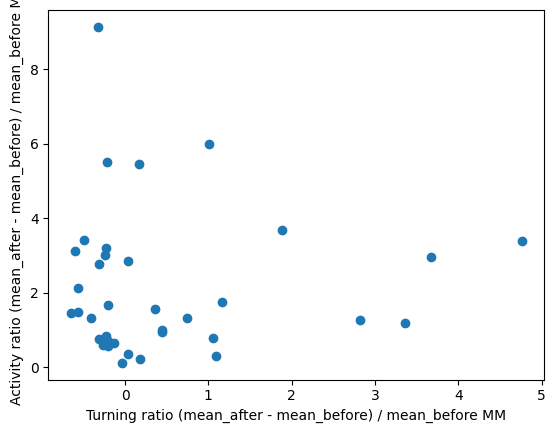

In [515]:
plt.scatter(ratio_turning, ratio_activ)
plt.xlabel("Turning ratio (mean_after - mean_before) / mean_before MM")
plt.ylabel("Activity ratio (mean_after - mean_before) / mean_before MM")
plt.show()

## Getting the running/turning speed and z_560 before and after MM

In [539]:
dict_turning_speed_before = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_turning_speed_after = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_running_speed_before = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_running_speed_after = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_activ_before = {MM: [] for MM in data_aligned_csv['halt_index']}
dict_activ_after = {MM: [] for MM in data_aligned_csv['halt_index']}

for i in range(np.max(data_aligned_csv['halt_index'])+1):
    spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == i]

    spe_halt_bin_before_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 2]
    spe_halt_bin_after_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 3]

    mean_turning_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0Y']))
    mean_turning_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0Y']))

    mean_running_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0X']))
    mean_running_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0X']))

    mean_activ_before = np.mean(spe_halt_bin_before_data['z_560'])
    mean_activ_after = np.mean(spe_halt_bin_after_data['z_560'])

    dict_turning_speed_before[i] = np.round(mean_turning_before, 2)
    dict_turning_speed_after[i] = np.round(mean_turning_after, 2)

    dict_running_speed_before[i] = np.round(mean_running_before, 2)
    dict_running_speed_after[i] = np.round(mean_running_after, 2)

    dict_activ_before[i] = np.round(mean_activ_before, 2)
    dict_activ_after[i] = np.round(mean_activ_after, 2)

print(dict_turning_speed_before)
mean_percentage_turning_speed_before = np.mean(list(dict_turning_speed_before.values()))
print(mean_percentage_turning_speed_before)
print(dict_turning_speed_after)
mean_percentage_turning_speed_after = np.mean(list(dict_turning_speed_after.values()))
print(mean_percentage_turning_speed_after)

print(dict_running_speed_before)
mean_percentage_running_speed_before = np.mean(list(dict_running_speed_before.values()))
print(mean_percentage_running_speed_before)
print(dict_running_speed_after)
mean_percentage_running_speed_after = np.mean(list(dict_running_speed_after.values()))
print(mean_percentage_running_speed_after)

print(np.mean(list(dict_activ_before)))
print(np.mean(list(dict_activ_after)))

{0: np.float64(116.95), 1: np.float64(146.25), 2: np.float64(33.83), 3: np.float64(118.34), 4: np.float64(118.44), 5: np.float64(145.3), 6: np.float64(24.69), 7: np.float64(13.96), 8: np.float64(164.26), 9: np.float64(111.29), 10: np.float64(75.97), 11: np.float64(25.18), 12: np.float64(25.51), 13: np.float64(132.47), 14: np.float64(145.53), 15: np.float64(283.55), 16: np.float64(51.59), 17: np.float64(198.78), 18: np.float64(137.81), 19: np.float64(117.24), 20: np.float64(94.65), 21: np.float64(25.58), 22: np.float64(134.29), 23: np.float64(176.6), 24: np.float64(297.75), 25: np.float64(103.12), 26: np.float64(84.73), 27: np.float64(69.54), 28: np.float64(44.92), 29: np.float64(128.1), 30: np.float64(84.88), 31: np.float64(121.09), 32: np.float64(250.79), 33: np.float64(217.67), 34: np.float64(274.21), 35: np.float64(84.05)}
121.63638888888889
{0: np.float64(80.47), 1: np.float64(64.27), 2: np.float64(147.32), 3: np.float64(81.01), 4: np.float64(247.81), 5: np.float64(114.44), 6: np.f

## Plotting the evolution of running/turning speed and activity before/after MM

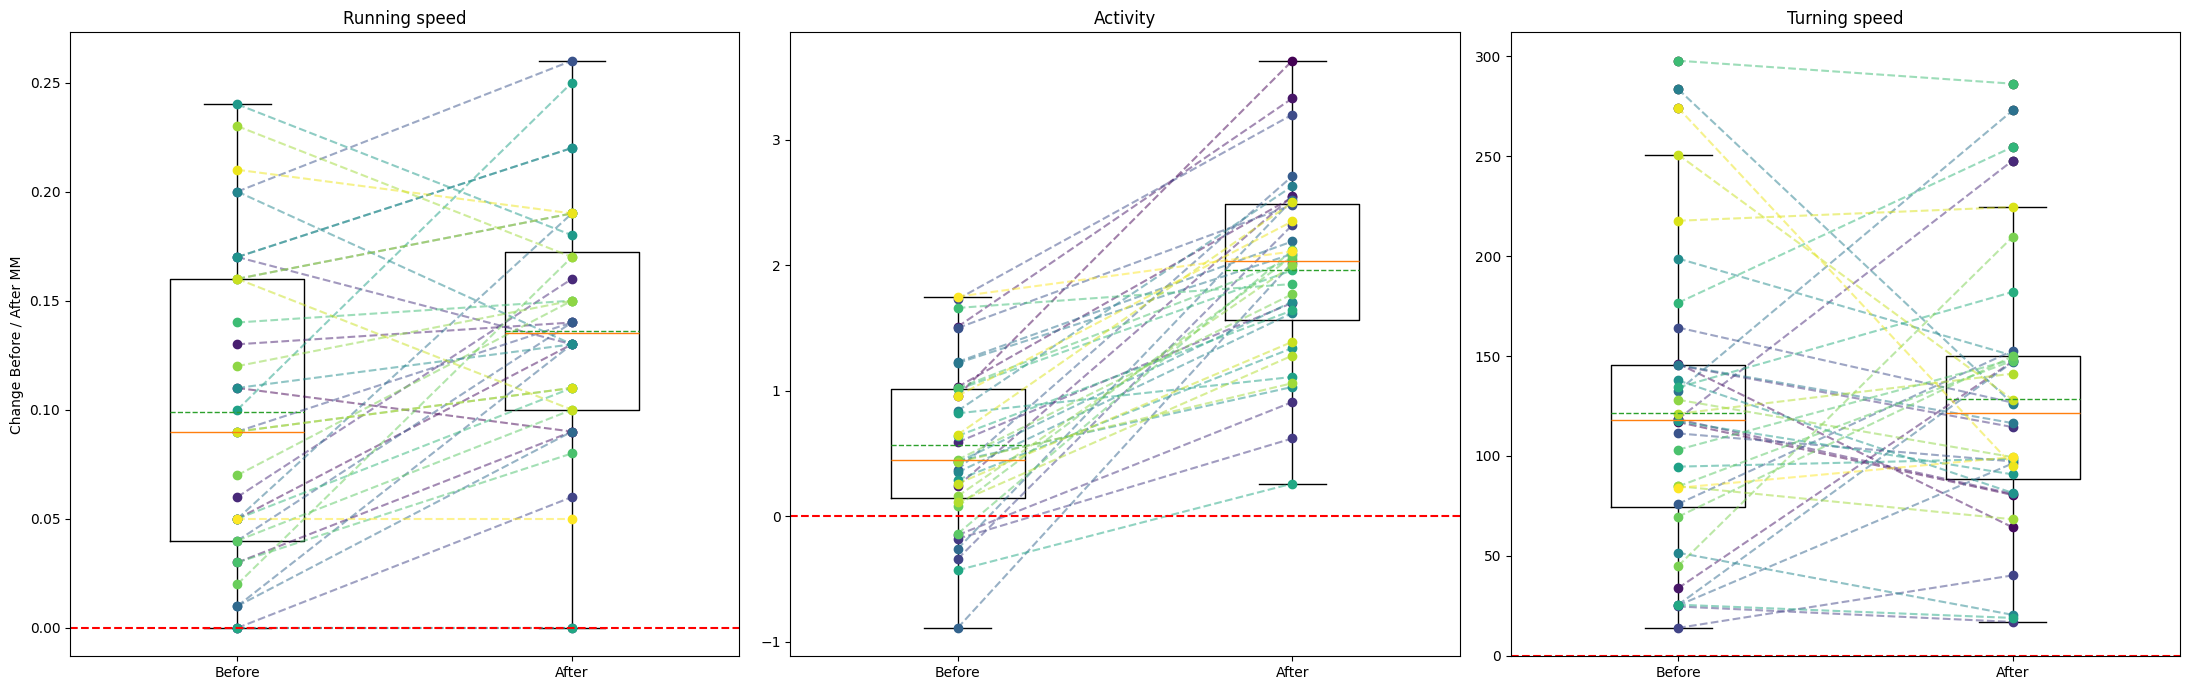

In [516]:
values_running_before, values_turning_before, values_activ_before, values_running_after, values_turning_after, values_activ_after = [], [], [], [], [], []
for i in range(np.max(data_aligned_csv['halt_index'])+1):
    values_running_before.append(dict_running_speed_before[i])
    values_running_after.append(dict_running_speed_after[i])
    values_turning_before.append(dict_turning_speed_before[i])
    values_turning_after.append(dict_turning_speed_after[i])
    values_activ_before.append(dict_activ_before[i])
    values_activ_after.append(dict_activ_after[i])

N=len(values_running_before)
data = [values_running_before, values_running_after, values_turning_before, values_turning_after, values_activ_before, values_activ_after]
cmap = cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=N-1)

fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharex=False)

datasets = [
    (values_running_before, values_running_after, 'Running speed', axes[0]),
    (values_activ_before, values_activ_after, 'Activity', axes[1]),
    (values_turning_before, values_turning_after, 'Turning speed', axes[2]),
]

for (before, after, title, ax) in datasets:
    ax.boxplot([before, after], positions=[1, 2], showmeans=True, meanline=True, widths=0.4)

    for i in range(N):
        color = cmap(norm(i))
        ax.plot(1, before[i], 'o', color=color)
        ax.plot(2, after[i], 'o', color=color)
        ax.plot([1, 2], [before[i], after[i]],
                linestyle='--', color=color, alpha=0.5)

    ax.axhline(0, color='r', linestyle='--')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before', 'After'])
    ax.set_title(title)

axes[0].set_ylabel('Change Before / After MM')
plt.tight_layout()
plt.show()


## Checking if data follow normal distribution

3.7164836406840527 0.1559465715683694


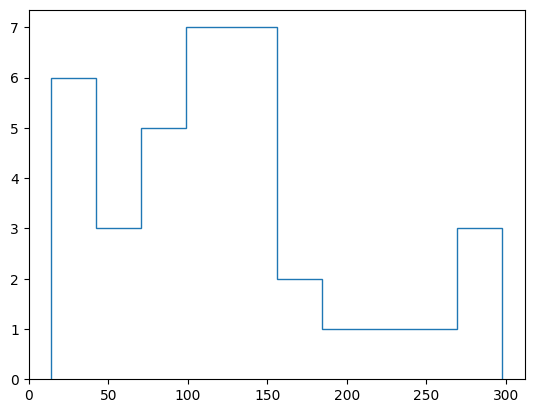

In [419]:
res = stats.normaltest(values_turning_before)

print(res.statistic, res.pvalue)

counts, bins = np.histogram(values_turning_before)
plt.stairs(counts, bins)

[np.float64(-36.480000000000004), np.float64(-81.98), np.float64(113.49), np.float64(-37.33), np.float64(129.37), np.float64(-30.860000000000014), np.float64(-7.740000000000002), np.float64(26.28), np.float64(-37.599999999999994), np.float64(-14.030000000000001), np.float64(76.66), np.float64(71.09), np.float64(121.48), np.float64(140.39000000000001), np.float64(-29.099999999999994), np.float64(-157.44), np.float64(-31.080000000000002), np.float64(-48.55000000000001), np.float64(-56.31), np.float64(-26.459999999999994), np.float64(3.9399999999999977), np.float64(-6.619999999999997), np.float64(47.77000000000001), np.float64(78.0), np.float64(-11.509999999999991), np.float64(45.109999999999985), np.float64(62.93999999999998), np.float64(80.34999999999998), np.float64(164.7), np.float64(-28.679999999999993), np.float64(-16.569999999999993), np.float64(20.079999999999984), np.float64(-122.65), np.float64(6.850000000000023), np.float64(-179.0), np.float64(15.36)]


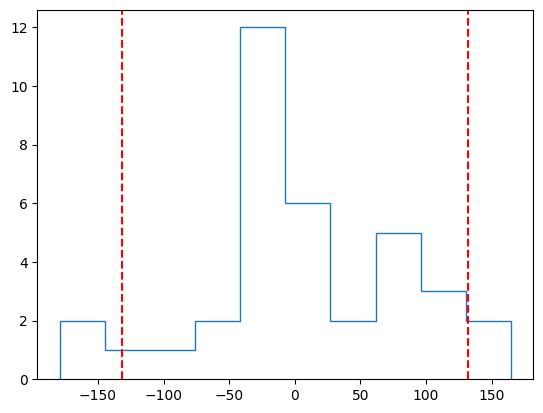

In [474]:
diff_turning, diff_running, diff_activ = [], [], []
for i in range(len(values_turning_after)):
    diff_t = values_turning_after[i] - values_turning_before[i]
    diff_r = values_running_after[i] - values_running_before[i]
    diff_a = values_activ_after[i] - values_activ_before[i]
    diff_turning.append(diff_t)
    diff_running.append(diff_r)
    diff_activ.append(diff_a)

print(diff_turning)

counts, bins = np.histogram(diff_turning)
res5 = np.percentile(diff_turning,5)
res95 = np.percentile(diff_turning,95)
plt.stairs(counts, bins)
plt.axvline(res5, color='r', linestyle='--')
plt.axvline(res95, color='r', linestyle='--')

## Checking if the change in speed/activity after MM is significant

In [452]:
# values_running_before
# values_running_after
# values_turning_before
# values_turning_after
# values_activ_before
# values_activ_after

def check_signif_change(data_before, data_after, threshold=2):
    median_before = np.median(data_before)

    # Compute Median Absolute Deviation
    deviation = np.abs(data_before - median_before)
    mad = np.median(deviation)

    # Apply scale factor for normally distributed data
    constant_mad = mad * 1.4826

    print(f'Median before : {median_before:.2f}')
    print(f'Threshold (corrected mad) : {constant_mad:.2f}')

    for i, val in enumerate(data_after):
        # Compute Z score
        z_score = np.abs(val - median_before) / constant_mad
        is_significant = z_score > threshold
        status = 'Significant' if is_significant else 'Not significant'
        print(f'Value #{i:<2} = {val:<8} | Score : {z_score:.2f} | {status}')

check_signif_change(values_turning_before, values_turning_after)

Median before : 117.79
Threshold (corrected mad) : 56.01
Value #0  = 80.47    | Score : 0.67 | Not significant
Value #1  = 64.27    | Score : 0.96 | Not significant
Value #2  = 147.32   | Score : 0.53 | Not significant
Value #3  = 81.01    | Score : 0.66 | Not significant
Value #4  = 247.81   | Score : 2.32 | Significant
Value #5  = 114.44   | Score : 0.06 | Not significant
Value #6  = 16.95    | Score : 1.80 | Not significant
Value #7  = 40.24    | Score : 1.38 | Not significant
Value #8  = 126.66   | Score : 0.16 | Not significant
Value #9  = 97.26    | Score : 0.37 | Not significant
Value #10 = 152.63   | Score : 0.62 | Not significant
Value #11 = 96.27    | Score : 0.38 | Not significant
Value #12 = 146.99   | Score : 0.52 | Not significant
Value #13 = 272.86   | Score : 2.77 | Significant
Value #14 = 116.43   | Score : 0.02 | Not significant
Value #15 = 126.11   | Score : 0.15 | Not significant
Value #16 = 20.51    | Score : 1.74 | Not significant
Value #17 = 150.23   | Score : 0.

## Plotting the % change of speed for running and turning

[np.float64(-0.31), np.float64(-0.56), np.float64(3.36), np.float64(-0.32), np.float64(1.09), np.float64(-0.21), np.float64(-0.31), np.float64(1.88), np.float64(-0.23), np.float64(-0.13), np.float64(1.01), np.float64(2.82), np.float64(4.76), np.float64(1.06), np.float64(-0.2), np.float64(-0.56), np.float64(-0.6), np.float64(-0.24), np.float64(-0.41), np.float64(-0.23), np.float64(0.04), np.float64(-0.26), np.float64(0.36), np.float64(0.44), np.float64(-0.04), np.float64(0.44), np.float64(0.74), np.float64(1.16), np.float64(3.67), np.float64(-0.22), np.float64(-0.2), np.float64(0.17), np.float64(-0.49), np.float64(0.03), np.float64(-0.65), np.float64(0.18)]


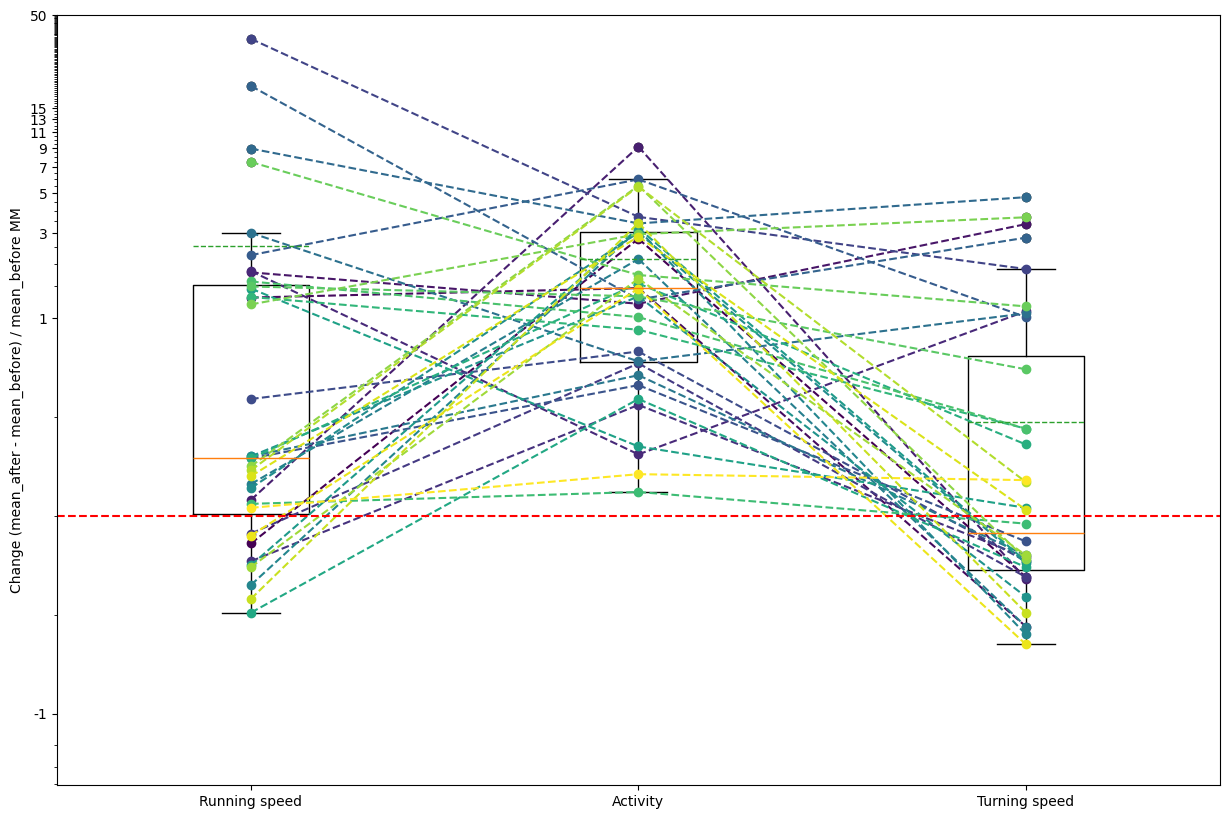

0.0005313188712165808 0.38319876261632835


In [517]:
values_running, values_turning, values_activ = [], [], []
for i in range(np.max(data_aligned_csv['halt_index'])+1):
    values_running.append(dict_changes_running_speed[i])
    values_turning.append(dict_changes_turning_speed[i])
    values_activ.append(dict_changes_activ[i])

print(values_turning)
N=len(values_running)
data = [values_running, values_activ, values_turning]
cmap = cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=N-1)


fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(data, positions=[1, 2, 3], showmeans=True, meanline=True, widths=0.3)
for i in range(N):
    color = cmap(norm(i)) 
    ax.plot(1, values_running[i], marker='o', color=color, linestyle='None')
    ax.plot(2, values_activ[i], marker='o', color=color, linestyle='None')
    ax.plot(3, values_turning[i], marker='o', color=color, linestyle='None')
    ax.plot([1,2], [values_running[i],values_activ[i]], marker='None', color=color, linestyle='--')
    ax.plot([2,3], [values_activ[i],values_turning[i]], marker='None', color=color, linestyle='--')
    
linear_ticks = np.arange(-1, 15, 2)
log_ticks = [15, 50]

ax.axhline(y=0, color='r', linestyle='--')
ax.set_yscale('symlog', linthresh=1)
ax.set_yticks(np.concatenate([linear_ticks, log_ticks]))
ax.set_yticklabels([str(t) for t in linear_ticks] + ['15', '50'])
ax.set_xticklabels(['Running speed', 'Activity', 'Turning speed'])
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
plt.ylabel('Change (mean_after - mean_before) / mean_before MM')
plt.show()


p_run = wilcoxon(values_running).pvalue
p_turn = wilcoxon(values_turning).pvalue
print(p_run, p_turn)

In [363]:
print(np.min(values_running))

-48.85


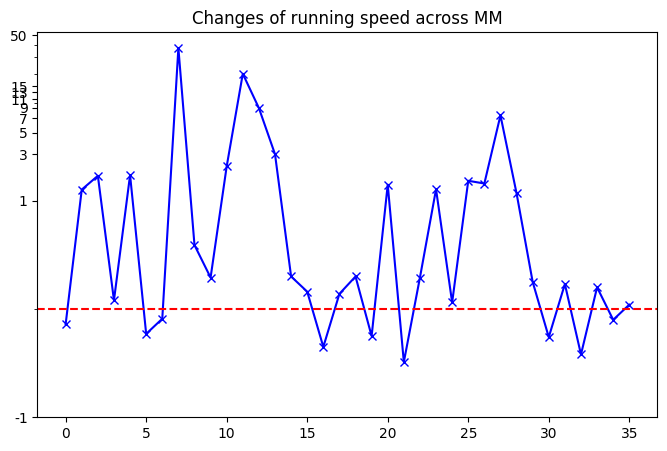

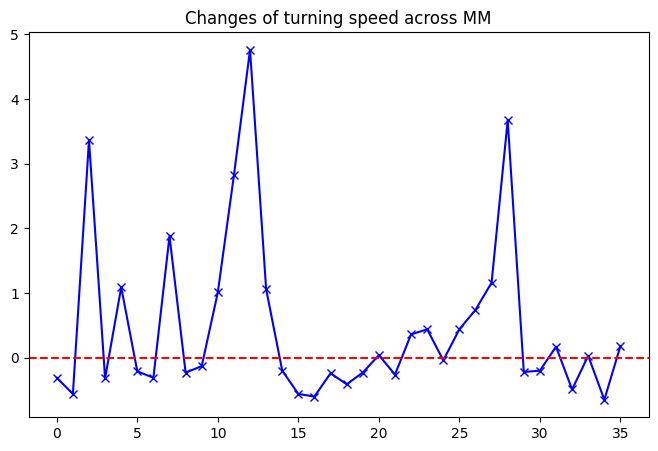

In [510]:
fig, ax = plt.subplots(figsize=(8, 5))
linear_ticks = np.arange(-1, 15, 2)
log_ticks = [15, 50]
ax.plot(range(len(values_running)), values_running, marker='x', color = 'blue')
ax.set_yscale('symlog', linthresh=1)
ax.set_yticks(np.concatenate([linear_ticks, log_ticks]))
ax.set_yticklabels([str(t) for t in linear_ticks] + ['15', '50'])
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.axhline(y=0, color='r', linestyle='--')
ax.set_title('Changes of running speed across MM')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
# linear_ticks = np.arange(-60, 300, 50)
# log_ticks = [500, 1000]
ax.plot(range(len(values_turning)), values_turning, marker='x', color = 'blue')
# ax.set_yscale('symlog', linthresh=20)
# ax.set_yticks(np.concatenate([linear_ticks, log_ticks]))
# ax.set_yticklabels([str(t) for t in linear_ticks] + ['500', '1000'])
# ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.axhline(y=0, color='r', linestyle='--')
ax.set_title('Changes of turning speed across MM')
plt.show()

In [519]:
# Setting of the MM wanted for visualisation and annalysis
MM_id = 0
Bin_id = 2
spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == MM_id]
spe_halt_bin_data = spe_halt_data.loc[spe_halt_data['bin_index'] == Bin_id]
# print(spe_halt_bin_data)

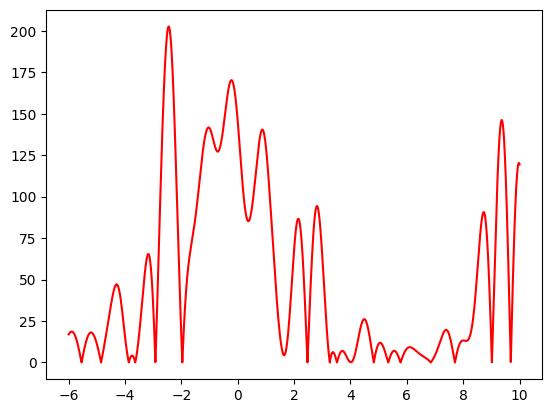

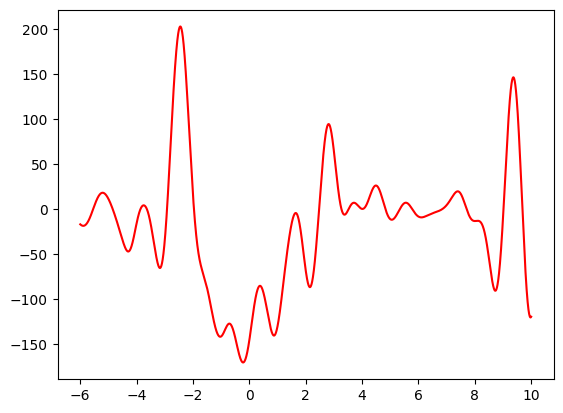

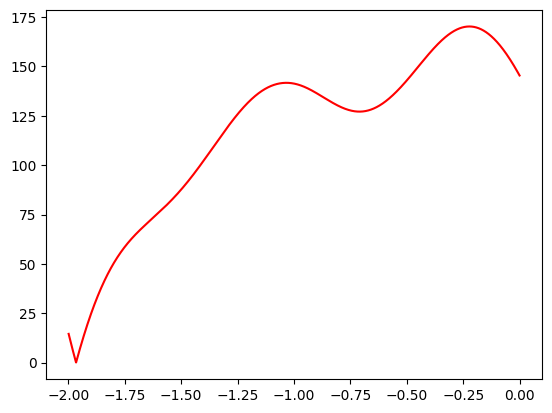

In [520]:
# Visualisation of the z score 560 for selected MM
plt.plot(spe_halt_data['Time (s)'], np.abs(spe_halt_data['Velocity_0Y']), color = 'red')
plt.show()

# for i in range(np.max(data_aligned_csv['halt_index'])):
#     spe_halt_data = data_aligned_csv.loc[data_aligned_csv['halt_index'] == i]
#     plt.plot(spe_halt_data['Time (s)'], spe_halt_data['Velocity_0Y'], color = 'red')
#     plt.show()

plt.plot(spe_halt_data['Time (s)'], spe_halt_data['Velocity_0Y'], color = 'red')
plt.show()

plt.plot(spe_halt_bin_data['Time (s)'], np.abs(spe_halt_bin_data['Velocity_0Y']), color = 'red')
plt.show()

In [202]:
np.max(data_aligned_csv['halt_index'])

35

In [274]:
spe_halt_bin_before_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 2]
spe_halt_bin_after_data = spe_halt_data.loc[spe_halt_data['bin_index'] == 3]

mean_before = np.mean(np.abs(spe_halt_bin_before_data['Velocity_0X']))
mean_after = np.mean(np.abs(spe_halt_bin_after_data['Velocity_0X']))
print(mean_before,mean_after)

ratio_before_after = (mean_after-mean_before)/mean_before
print(ratio_before_after)

# if ratio_before_after > 1:
#     ratio_before_after -=1
#     ratio_before_after *=(-1)

# if ratio_before_after < 1:
#     ratio_before_after = 1 -ratio_before_after

print(f'Mean speed change : {np.round(ratio_before_after*100, 2)}% after MM.')


0.006301400000000001 0.13266245000000002
20.0528533341797
Mean speed change : 2005.29% after MM.


## Correlation 1v1 and correlation matrix

Correlation between z_560 and Position_0X: -0.2973878954102687
z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


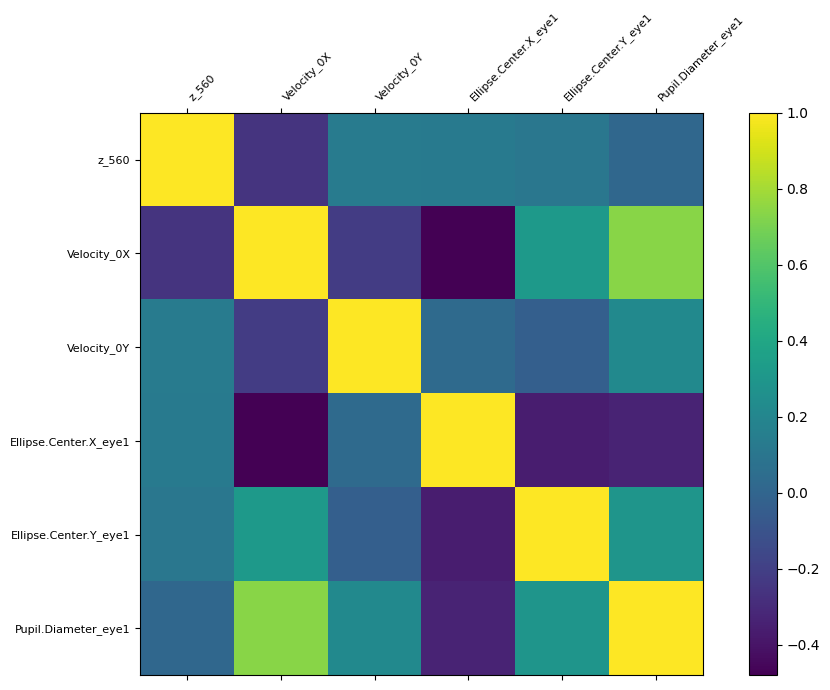

In [547]:
# red = gecko = 560 --> z_560 used for neural activity
# motor_velocity, velocity_0Y, Velocity_0X, saccade_probability_eye1, pupil (elipse ?) diameter

# The two features you want to see the correlation of
c1 = spe_halt_data['z_560']
c2 = spe_halt_data['Position_0X']
numpy_correlation = np.corrcoef(c1, c2)[0, 1]
print(f'Correlation between {c1.name} and {c2.name}:', numpy_correlation)

# Correlation matrix of all features minus what is specified line just below
spe_halt_data_no_bs = spe_halt_data.drop(['Position_0Y', 'Position_0X', 'bin_index', 'saccade_probability_eye1', 'Acceleration_0Y', 'Acceleration_0X', 'Motor_Acceleration', 'Motor_Velocity', 'Time (s)', 'Halt Time', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'halt_index', 'CumulativeCounts_0X', 'CumulativeCounts_0Y','saccade_event_eye1','saccade_event_eye2'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
col_names = spe_halt_data_no_bs.columns
print("\n".join(col_names))
# position of pupils in absolute values
table_global_ratio_abs = table_global_ratio
spe_halt_data_no_bs['Ellipse.Center.X_eye1'] = abs(spe_halt_data_no_bs['Ellipse.Center.X_eye1'])
spe_halt_data_no_bs['Ellipse.Center.Y_eye1'] = abs(spe_halt_data_no_bs['Ellipse.Center.Y_eye1'])
spe_halt_data_no_bs['Pupil.Diameter_eye1'] = abs(spe_halt_data_no_bs['Pupil.Diameter_eye1'])
corr = spe_halt_data_no_bs.corr()
n = corr.shape[0]

fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(corr)

ax.set_xticks(np.arange(n), corr.columns, fontsize=8, rotation=45, ha='left')
ax.set_yticks(np.arange(n), corr.columns, fontsize=8)

plt.colorbar(cax, ax=ax)
plt.tight_layout()
plt.show()

z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


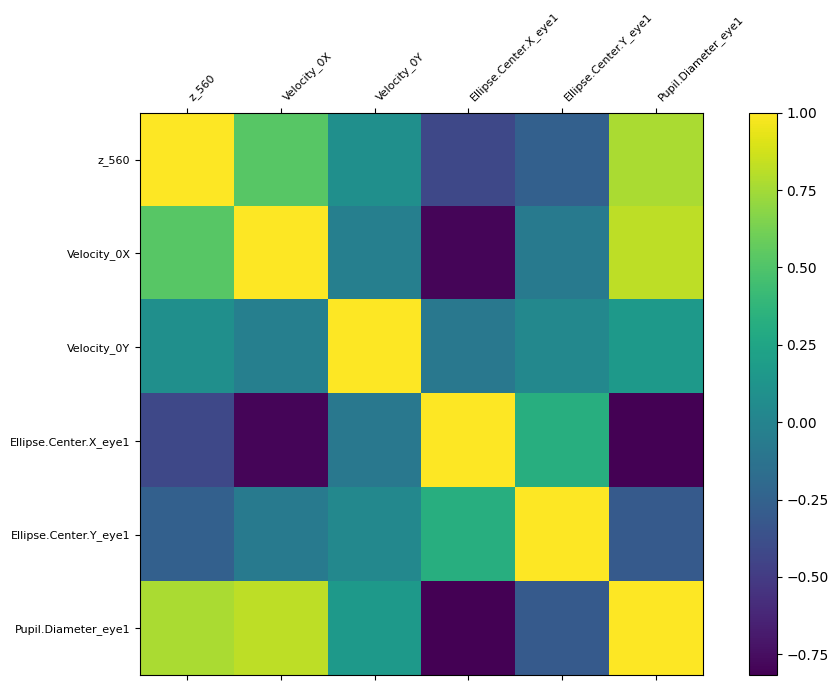

z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


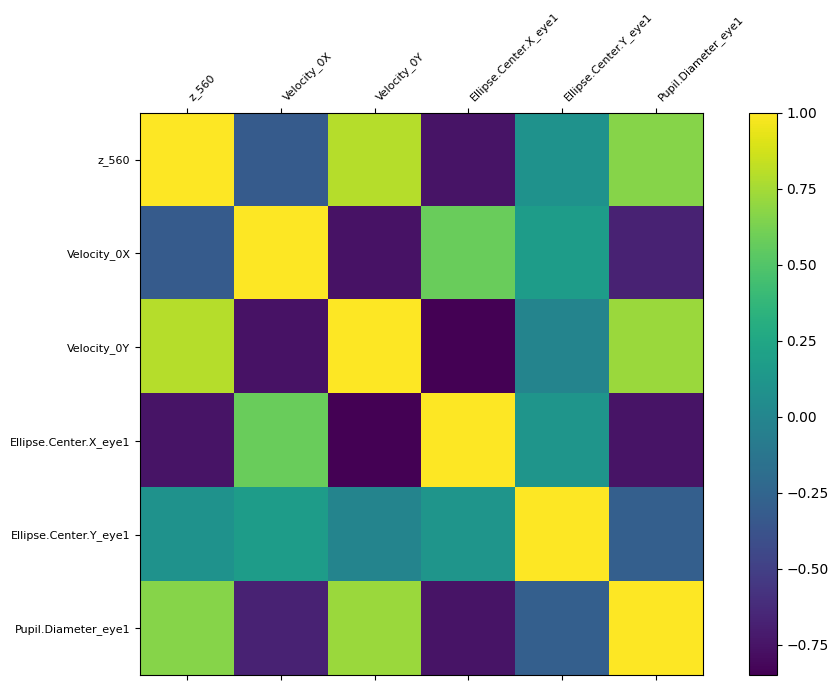

z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


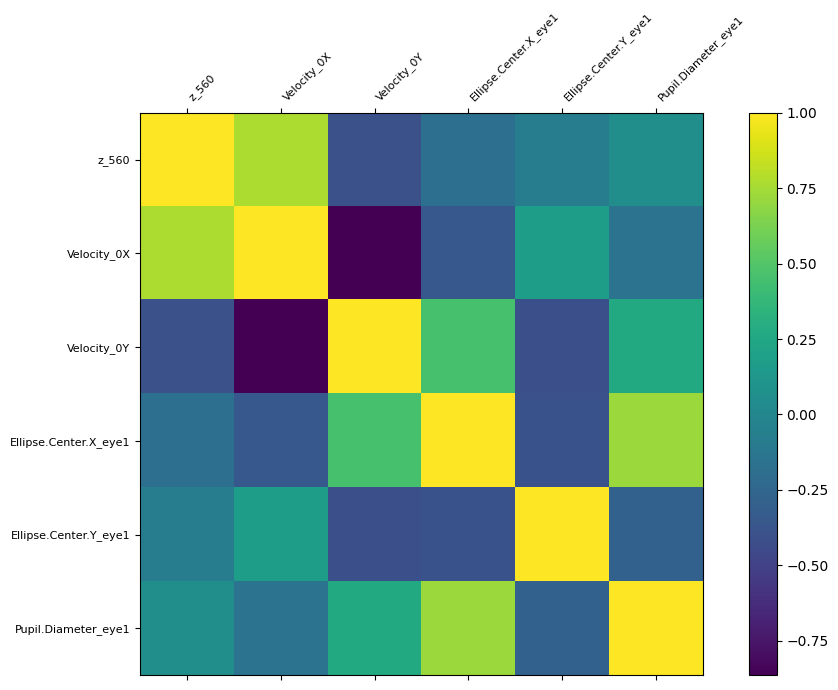

z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


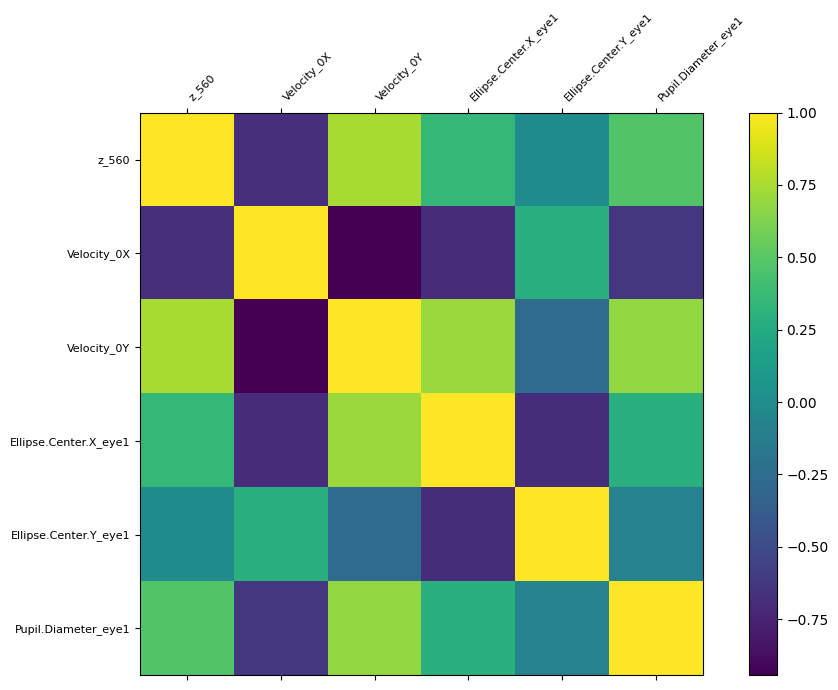

z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


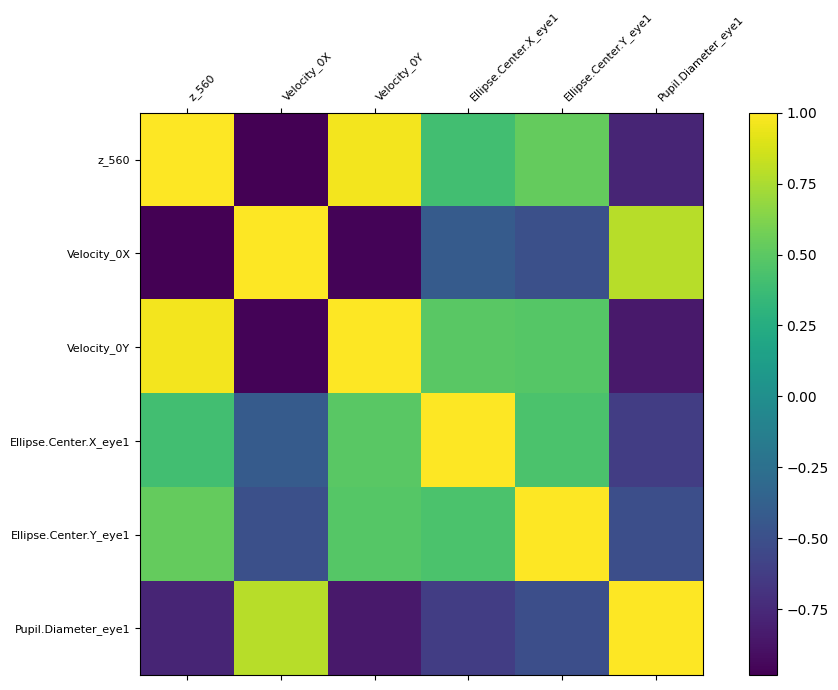

z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


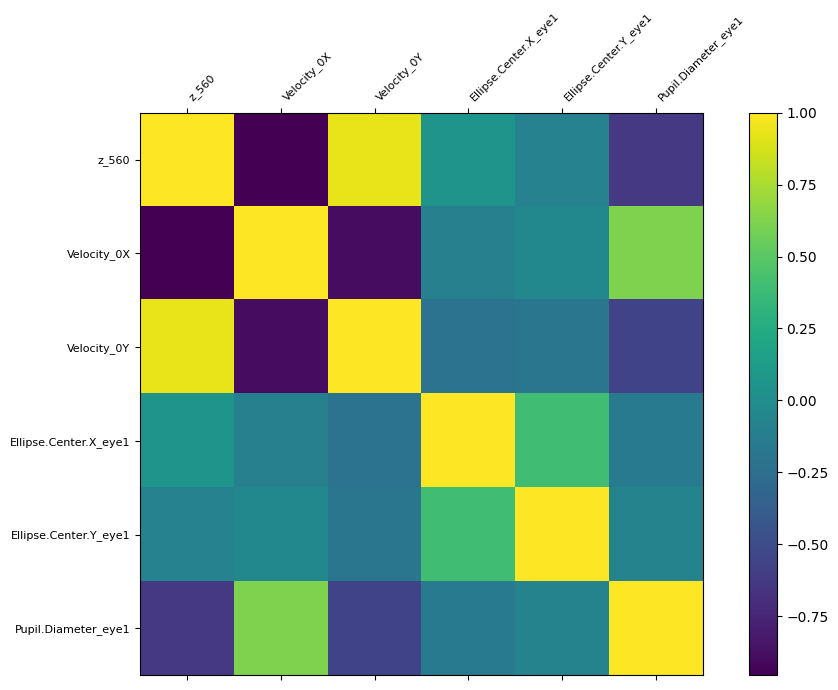

z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


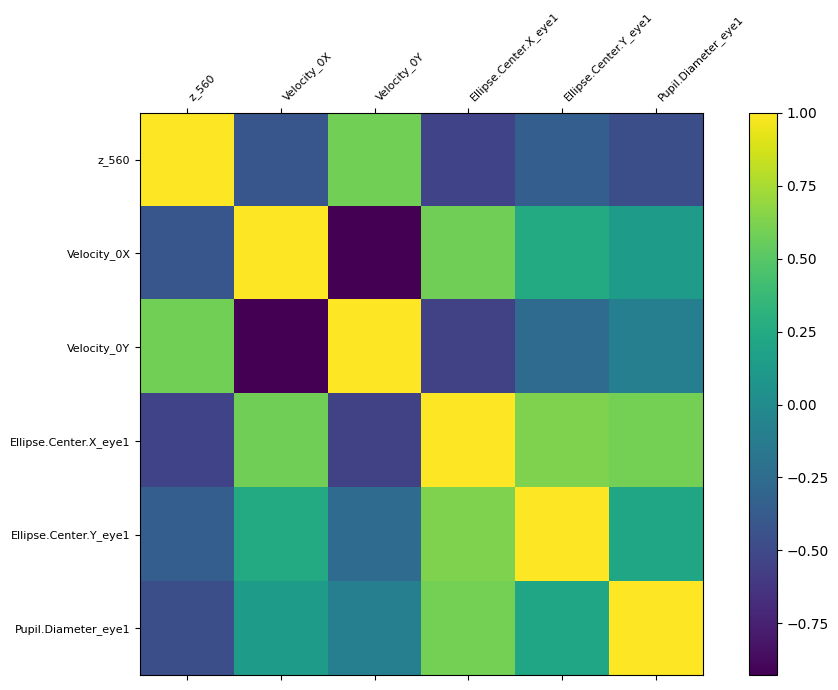

z_560
Velocity_0X
Velocity_0Y
Ellipse.Center.X_eye1
Ellipse.Center.Y_eye1
Pupil.Diameter_eye1


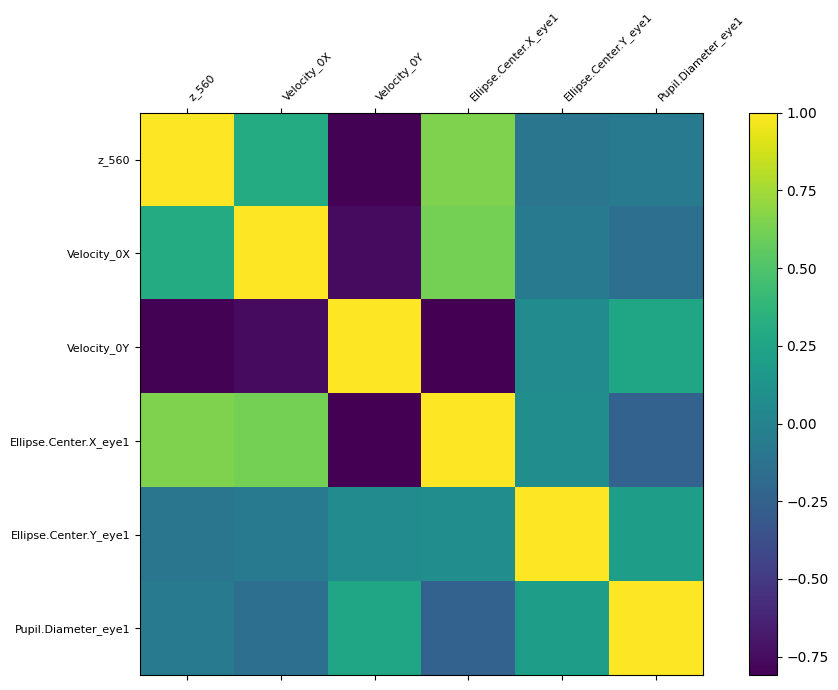

In [574]:
# Correlation matrix of all features minus what is specified line just below
# spe_halt_bin_before_data
# spe_halt_bin_after_data
for Bin_id in range(0, 8):
    spe_halt_bin_data = spe_halt_data.loc[spe_halt_data['bin_index'] == Bin_id]
    spe_halt_bin_data_no_bs = spe_halt_bin_data.drop(['Position_0Y', 'Position_0X', 'bin_index', 'saccade_probability_eye1', 'Acceleration_0Y', 'Acceleration_0X', 'Motor_Acceleration', 'Motor_Velocity', 'Time (s)', 'Halt Time', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'halt_index', 'CumulativeCounts_0X', 'CumulativeCounts_0Y','saccade_event_eye1','saccade_event_eye2'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
    col_names = spe_halt_bin_data_no_bs.columns
    print("\n".join(col_names))
    # position of pupils in absolute values
    spe_halt_bin_data_no_bs['Ellipse.Center.X_eye1'] = abs(spe_halt_bin_data_no_bs['Ellipse.Center.X_eye1'])
    spe_halt_bin_data_no_bs['Ellipse.Center.Y_eye1'] = abs(spe_halt_bin_data_no_bs['Ellipse.Center.Y_eye1'])
    corr = spe_halt_bin_data_no_bs.corr()
    n = corr.shape[0]

    fig, ax = plt.subplots(figsize=(10, 7))
    cax = ax.matshow(corr)

    ax.set_xticks(np.arange(n), corr.columns, fontsize=8, rotation=45, ha='left')
    ax.set_yticks(np.arange(n), corr.columns, fontsize=8)

    plt.colorbar(cax, ax=ax)
    plt.tight_layout()
    plt.show()

In [14]:
x = np.column_stack([spe_halt_data['Motor_Velocity'], spe_halt_data['Velocity_0X'], spe_halt_data['Velocity_0Y'], spe_halt_data['Pupil.Diameter_eye1'], spe_halt_data['Ellipse.Center.X_eye1'], spe_halt_data['Ellipse.Center.Y_eye1']]) # , spe_halt_data['saccade_probability_eye1'], spe_halt_data['saccade_event_eye1']
y = spe_halt_data['z_560']

model = LinearRegression().fit(x, y)

print('multiple linear regression coef:', model.coef_) 
print('multiple linear regression R²:', model.score(x, y))

multiple linear regression coef: [-2.38445273e-02  1.04271682e+01 -2.36061451e-04  2.66986280e-01
 -1.11279801e-02  2.10992398e-01]
multiple linear regression R²: 0.7129442382267325


In [170]:
# a = spe_halt_data.drop(['z_560', 'Halt Time'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
# b = spe_halt_data['z_560']

# scaler = StandardScaler()
# a_scaled = scaler.fit_transform(a)
# print(a_scaled)

# def compute_auc(ax2, ax1=spe_halt_data['Time (s)']):
#     if ax2 is None:
#         print('No variable mentionned. Please determine ax2')
#         return None
#     AUC = auc(ax1, ax2)
#     return AUC

# AUC = compute_auc(ax2=spe_halt_data['z_560'])
# print(AUC)

[[-2.50027057 -1.78525037  2.51999211 ... -0.67416922  0.
  -1.52736614]
 [-2.49982387 -1.78507936  2.51953302 ... -0.67416922  0.
  -1.52736614]
 [-2.49937475 -1.78507936  2.51908315 ... -0.67416922  0.
  -1.52736614]
 ...
 [ 0.26377706  1.04534196 -0.24900025 ... -0.67416922  0.
   1.52755706]
 [ 0.26377706  1.04534196 -0.24899636 ... -0.67416922  0.
   1.52755706]
 [ 0.26377706  1.04534196 -0.24899288 ... -0.67416922  0.
   1.52755706]]


NameError: name 'auc' is not defined

## PCA : Whithout considering z_560, create new uncorrelated variables that explain the variance the most
## Detail features present in new principal components

In [566]:
# Keep only numeric columns
a = spe_halt_data.drop(['Position_0Y', 'Position_0X', 'bin_index', 'saccade_probability_eye1', 'Acceleration_0Y', 'Acceleration_0X', 'Motor_Acceleration', 'Motor_Velocity', 'Time (s)', 'Halt Time', 'Encoder', 'Encoder_Unwrapped', 'dfF_470', 'dfF_560', 'dfF_410', 'z_470', 'z_410', 'Photodiode_int', 'halt_index', 'CumulativeCounts_0X', 'CumulativeCounts_0Y','saccade_event_eye1','saccade_event_eye2'], axis=1) # 'saccade_event_eye1', 'saccade_event_eye2'
spe_halt_data_num = a.select_dtypes(include=[np.number])

# Target variable
target = "z_560"

# Drop rows with NaNs
spe_halt_data_num = spe_halt_data_num.dropna()

# Separate z_560
y = spe_halt_data_num[target].values
X = spe_halt_data_num.drop(columns=[target])

# Z-score variables
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(Xz)


explained_var = pca.explained_variance_ratio_

feature_names = X.columns

for pc_idx, (var, component) in enumerate(zip(explained_var, pca.components_)):

    loadings = pd.Series(component, index=feature_names)

    # Sort by absolute loading
    loadings_sorted = loadings.reindex(
        loadings.abs().sort_values(ascending=False).index
    )

    print(f"\nPC{pc_idx+1}: {var*100:.2f}% variance explained")
    for feature, value in loadings_sorted.items():
        print(f"{feature:25s} {value:+.3f}")



PC1: 48.99% variance explained
Velocity_0X               +0.535
Pupil.Diameter_eye1       +0.525
Ellipse.Center.Y_eye1     +0.463
Ellipse.Center.X_eye1     -0.461
Velocity_0Y               -0.104

PC2: 24.08% variance explained
Velocity_0Y               +0.856
Pupil.Diameter_eye1       +0.415
Ellipse.Center.X_eye1     +0.307
Ellipse.Center.Y_eye1     +0.016
Velocity_0X               +0.011

PC3: 14.44% variance explained
Ellipse.Center.Y_eye1     +0.626
Velocity_0X               -0.574
Ellipse.Center.X_eye1     -0.385
Velocity_0Y               +0.257
Pupil.Diameter_eye1       -0.254

PC4: 9.76% variance explained
Ellipse.Center.X_eye1     +0.724
Ellipse.Center.Y_eye1     +0.627
Velocity_0Y               -0.219
Velocity_0X               +0.149
Pupil.Diameter_eye1       -0.113

PC5: 2.73% variance explained
Pupil.Diameter_eye1       +0.689
Velocity_0X               -0.602
Velocity_0Y               -0.376
Ellipse.Center.X_eye1     +0.143
Ellipse.Center.Y_eye1     -0.029


## Correlation of each PC with target z_560

In [575]:
pc_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

pc_y_corr = pc_df.apply(lambda pc: np.corrcoef(pc, y)[0,1]) # pearson correlation between each pc and y (target)

print(f'\n{pc_y_corr.sort_values(key=np.abs, ascending=False)}')



PC3    0.374803
PC5    0.234505
PC4   -0.144616
PC2    0.069399
PC1   -0.006299
dtype: float64


## PLS Regression : Which features explain variance in X that is also predictive of y

In [576]:
pls = PLSRegression(n_components=5)
pls.fit(Xz, y)

pls_loadings = pd.Series(pls.x_weights_[:,0], index=X.columns)
pls_loadings.sort_values(key=np.abs, ascending=False)

Velocity_0X              0.719340
Ellipse.Center.X_eye1    0.439886
Velocity_0Y             -0.389093
Ellipse.Center.Y_eye1   -0.368052
Pupil.Diameter_eye1     -0.046848
dtype: float64

## Ridge Regression

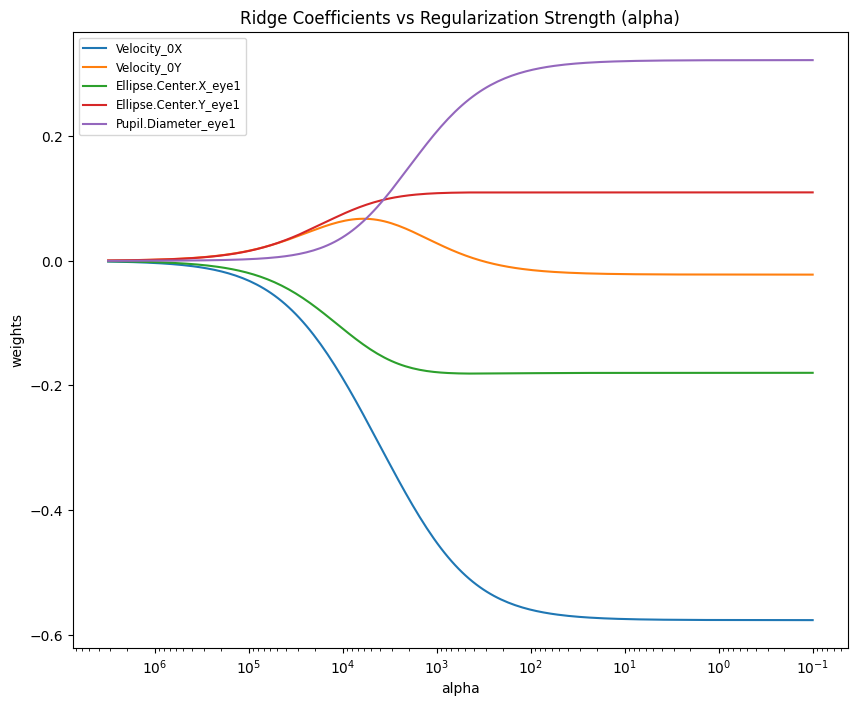

In [571]:
n_alphas = 200
alphas = np.logspace(-1, 6.5, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(Xz, y)
    coefs.append(ridge.coef_)

plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge Coefficients vs Regularization Strength (alpha)")
plt.axis("tight")
plt.legend(
    [feature_names[i] for i in range(X.shape[1])], loc="upper left", fontsize="small"
)
plt.show()

Best alpha: 3162277.660168379


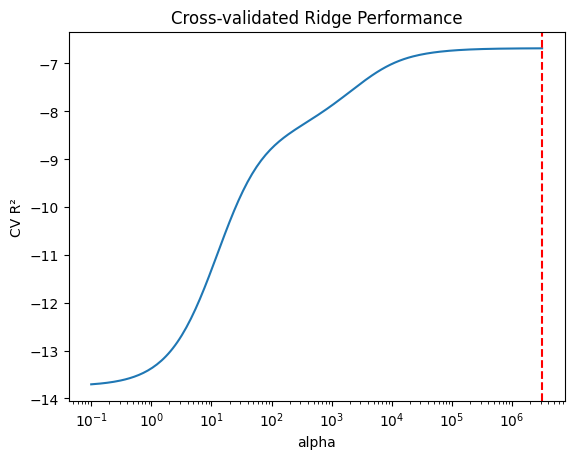

In [572]:
tscv = TimeSeriesSplit(n_splits=5)

mean_scores = []

for a in alphas:
    scores = []
    for train_idx, test_idx in tscv.split(Xz):
        model = Ridge(alpha=a, fit_intercept=False)
        model.fit(Xz[train_idx], y[train_idx])
        y_pred = model.predict(Xz[test_idx])
        scores.append(r2_score(y[test_idx], y_pred))
    mean_scores.append(np.mean(scores))

mean_scores = np.array(mean_scores)

best_alpha = alphas[np.argmax(mean_scores)]
print("Best alpha:", best_alpha)

plt.figure()
plt.semilogx(alphas, mean_scores)
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel("alpha")
plt.ylabel("CV R²")
plt.title("Cross-validated Ridge Performance")
plt.show()

/tmp/ipykernel_284750/4192464950.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coefs_at_best_alpha = coefs[int(np.where(alphas == best_alpha)[0])]


Velocity_0X             -0.001109
Ellipse.Center.X_eye1   -0.000678
Velocity_0Y              0.000598
Ellipse.Center.Y_eye1    0.000567
Pupil.Diameter_eye1      0.000073
dtype: float64


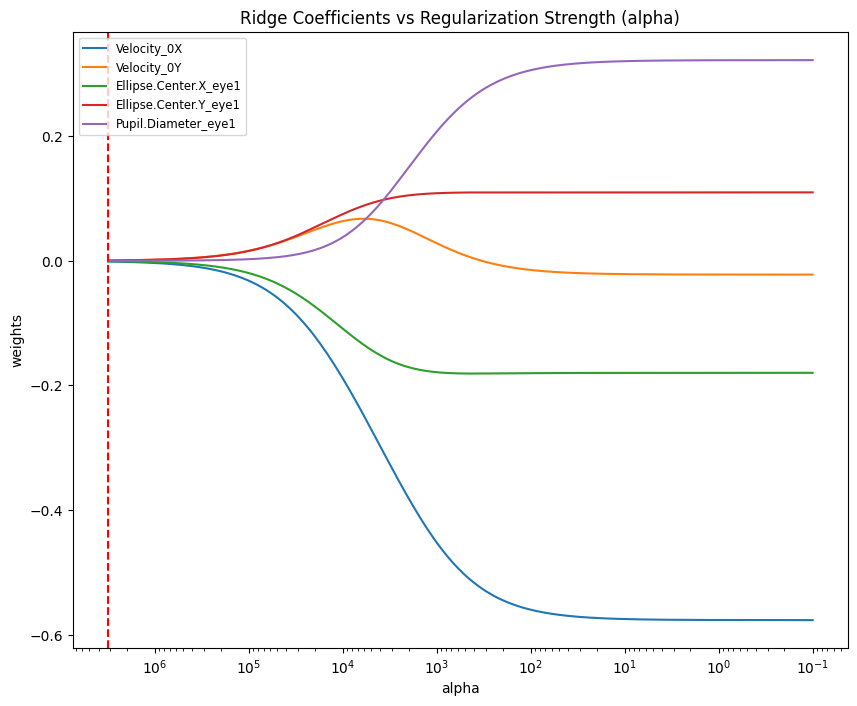

In [573]:
coefs_at_best_alpha = coefs[int(np.where(alphas == best_alpha)[0])]
coef_best_alpha_organized = pd.Series(coefs_at_best_alpha, index=X.columns)
print(coef_best_alpha_organized.sort_values(key=np.abs, ascending=False))

plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axvline(best_alpha, color='r', linestyle='--')
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge Coefficients vs Regularization Strength (alpha)")
plt.axis("tight")
plt.legend(
    [feature_names[i] for i in range(X.shape[1])], loc="upper left", fontsize="small"
)
plt.show()